Mounted at /content/drive
 Loaded: Wall1_1.jpg
 Loaded: Wall1_2.jpg
 Loaded: Wall1_3.jpg
 Loaded: Wall1_4.jpg
 Loaded: Wall1_5.jpg
 Loaded: Wall1_6.jpg
 Loaded: Wall1_7.jpg
 Loaded: Wall1_8.jpg
 Loaded: Wall1_9.jpg
 Loaded: Wall1_10.jpg

Total images loaded: 10

STEP 1: Feature Matching Visualization


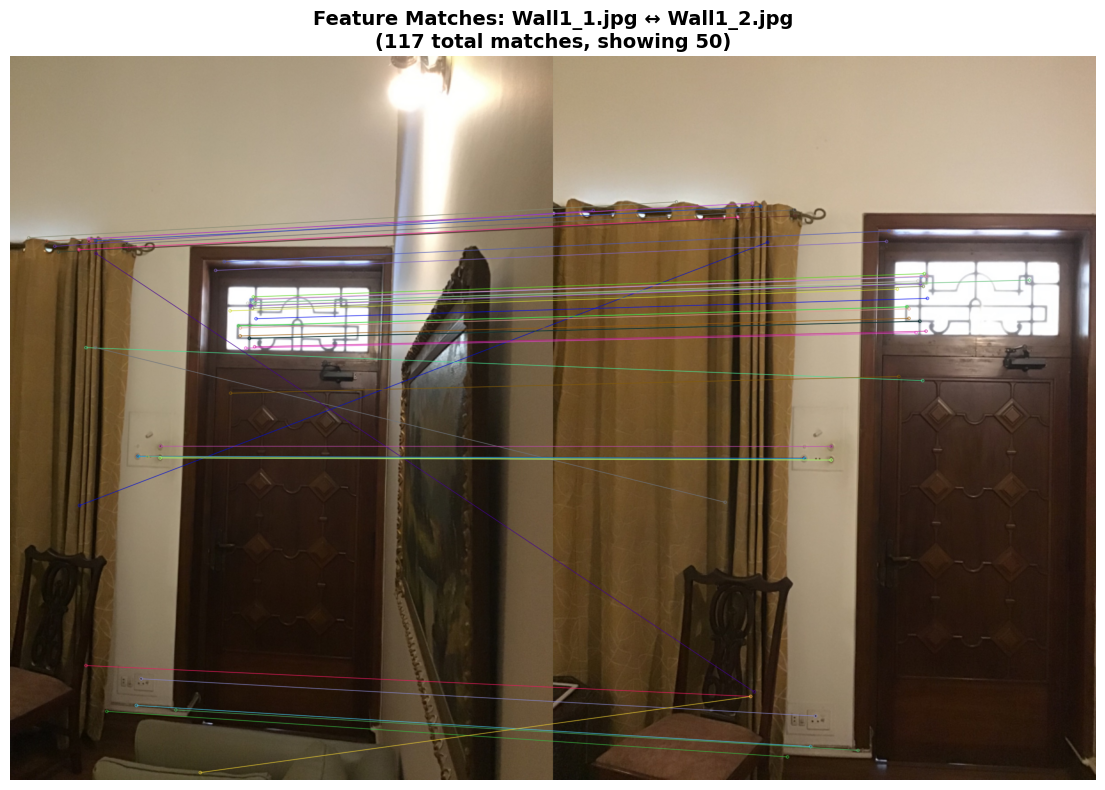


STEP 2: 3D Reconstruction

Two-View Reconstruction: Wall1_1.jpg ↔ Wall1_2.jpg
Feature Matching
Keypoints found: 2341 in img1, 1769 in img2
Good matches after strict ratio test: 164
2.Camera Calibration
3.Essential Matrix Estimation
Inlier matches after RANSAC: 87
4.Pose Recovery & Disambiguation
Rotation Matrix R recovered
Translation Vector t: [0.831, 0.046, -0.555]
5.Triangulation & Point Cloud Generation
Total 3D points triangulated: 87
Valid 3D points (in front of both cameras): 87

STEP 3: Saving Results
Point cloud saved to: week2_pointcloud.ply
 File week2_pointcloud.ply is saved in Colab

STEP 4: Depth Analysis

DEPTH ANALYSIS:
• Depth range: [3.828, 4.502]
• Depth range size: 0.675
• Depth std: 0.172
• Depth mean: 4.362
Good depth variation detected!
•Foreground points: 42
•Background points: 45
•Foreground depth: [3.828, 4.431]
•Background depth: [4.432, 4.502]

STEP 5: Visualization


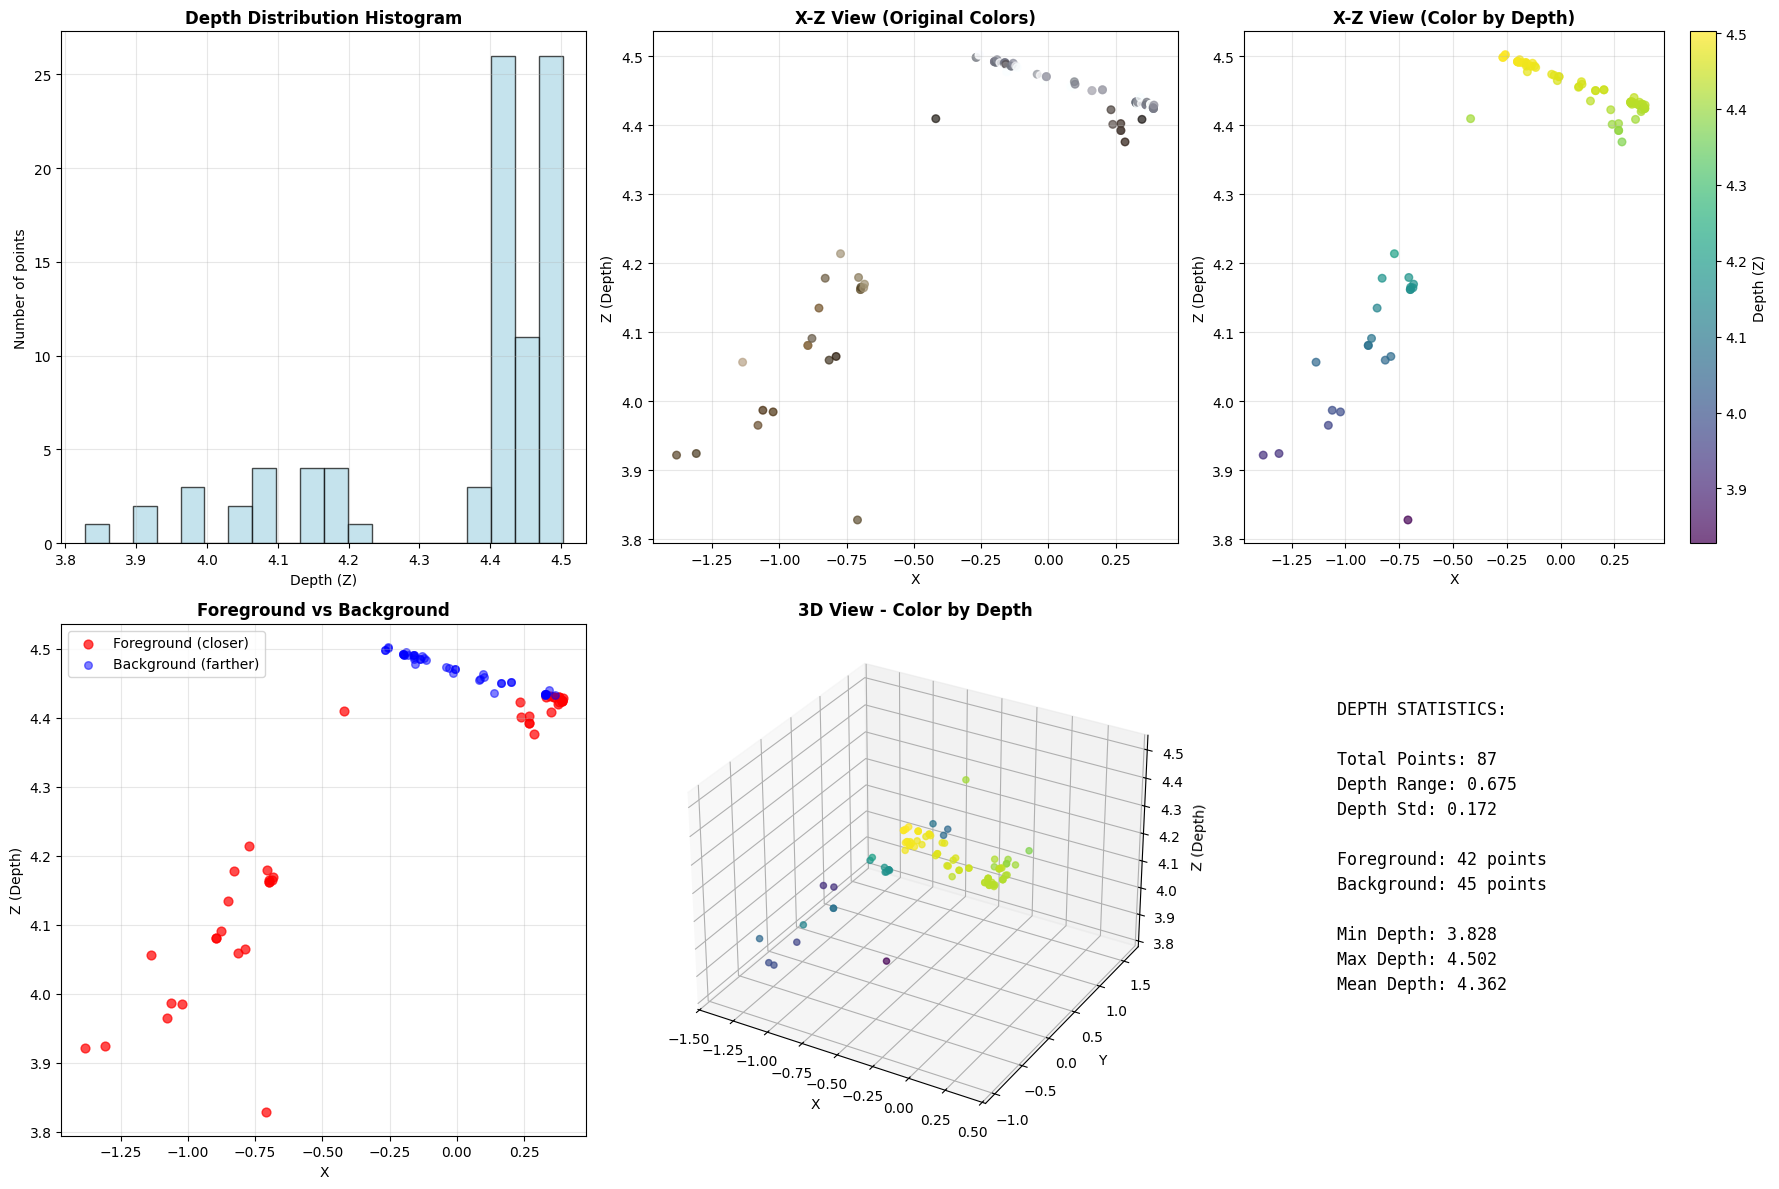


STEP 6: 2D Scatter Plots


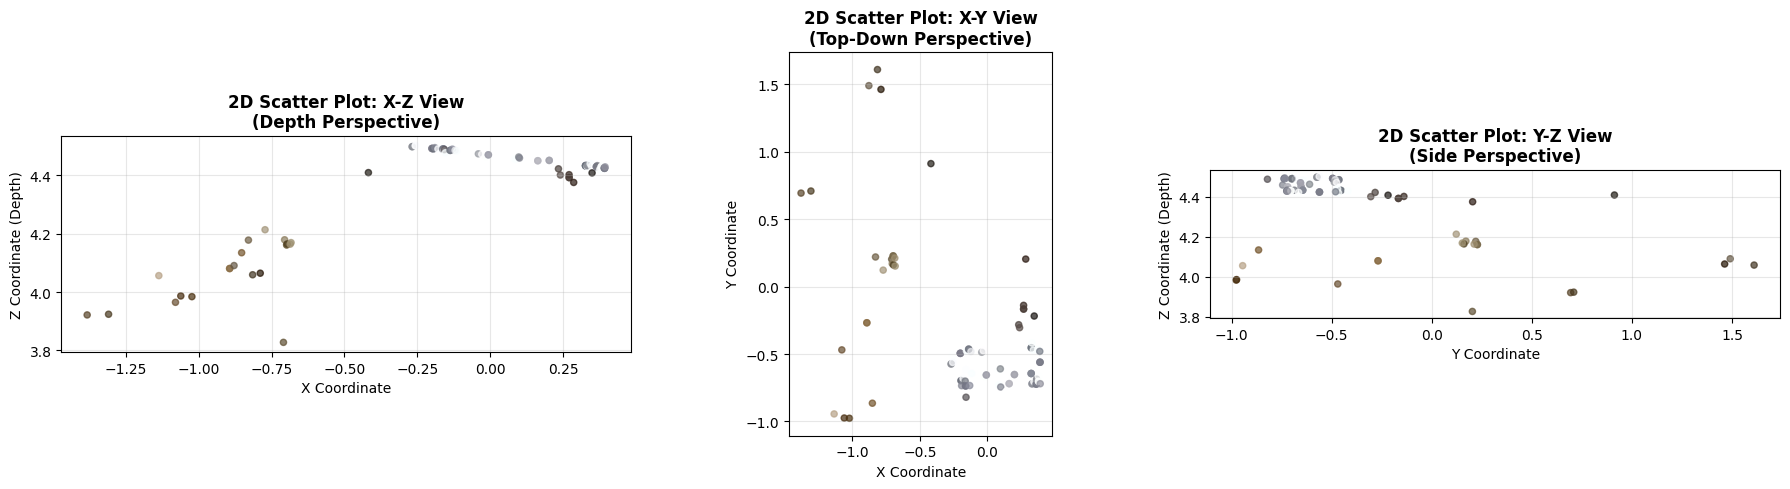

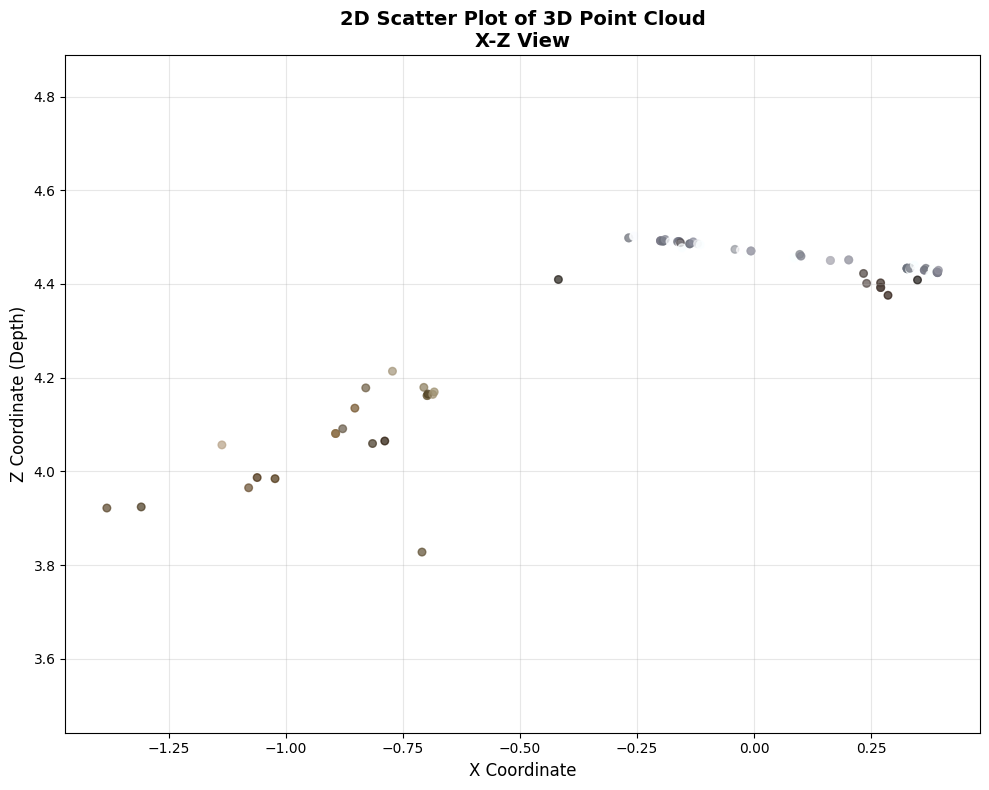


STEP 7: Interactive 3D Visualization


In [2]:
# ======
# WEEK 2
# ======
!pip install open3d plotly scipy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import open3d as o3d
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go
from plotly.subplots import make_subplots

drive.mount('/content/drive')

#base_path = '/content/drive/MyDrive/CV_project/Wall1'

def load_all_images_sequentially(folder_path):
    images = []
    filenames = []

    for i in range(1, 11):
        filename = f"Wall1_{i}.jpg"
        filepath = os.path.join(folder_path, filename)

        if os.path.exists(filepath):
            img = cv2.imread(filepath)
            if img is not None:
                images.append(img)
                filenames.append(filename)
                print(f" Loaded: {filename}")
            else:
                print(f" Failed to load: {filename}")
        else:
            print(f"File not found: {filepath}")

    print(f"\nTotal images loaded: {len(images)}")
    return images, filenames

def two_view_reconstruction_enhanced(img1, img2, filename1, filename2):

    print(f"\nTwo-View Reconstruction: {filename1} ↔ {filename2}")
    print("="*60)

    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    print("Feature Matching")
    sift = cv2.SIFT_create(nfeatures=5000,contrastThreshold=0.02,edgeThreshold=10)

    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    print(f"Keypoints found: {len(kp1)} in img1, {len(kp2)} in img2")

    FLANN_INDEX_KDTREE = 1
    index_params =dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params =dict(checks=100)
    flann =cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    print(f"Good matches after strict ratio test: {len(good_matches)}")
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    print("2.Camera Calibration")
    h, w = img1.shape[:2]

    # Camera intrinsic matrix
    #fx = fy = w
    fx = fy = max(w, h)
    cx, cy = w/2, h/2

    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0, 0, 1]])

    print("3.Essential Matrix Estimation")
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=0.5,  maxIters=2000)

    pts1_inliers = pts1[mask.ravel() == 1]
    pts2_inliers = pts2[mask.ravel() == 1]

    print(f"Inlier matches after RANSAC: {len(pts1_inliers)}")

    print("4.Pose Recovery & Disambiguation")
    _, R_mat, t_vec, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

    print(f"Rotation Matrix R recovered")
    print(f"Translation Vector t: [{t_vec[0,0]:.3f}, {t_vec[1,0]:.3f}, {t_vec[2,0]:.3f}]")

    print("5.Triangulation & Point Cloud Generation")

    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((R_mat, t_vec))

    P1 = K @ P1
    P2 = K @ P2

    points_4d = cv2.triangulatePoints(P1, P2, pts1_inliers.T, pts2_inliers.T)
    points_3d = points_4d[:3] / points_4d[3]
    points_3d = points_3d.T

    points_cam2 = (R_mat @ points_3d.T + t_vec.ravel()[:, np.newaxis]).T
    valid_z1 = points_3d[:, 2] > 0
    valid_z2 = points_cam2[:, 2] > 0
    valid_mask = valid_z1 & valid_z2

    points_3d_valid = points_3d[valid_mask]
    pts1_valid = pts1_inliers[valid_mask]

    print(f"Total 3D points triangulated: {len(points_3d)}")
    print(f"Valid 3D points (in front of both cameras): {len(points_3d_valid)}")

    colors = []
    for i, (u, v) in enumerate(pts1_valid):
        if 0 <= int(v) < h and 0 <= int(u) < w:
            colors.append(img1[int(v), int(u)][::-1])
        else:
            colors.append([255, 255, 255])
    colors = np.array(colors) / 255.0
    return points_3d_valid, colors, E, R_mat, t_vec, len(points_3d_valid)

def analyze_depth_distribution(points_3d):
    if len(points_3d) == 0:
        return "FLAT", 0

    z_values = points_3d[:, 2]
    depth_range = z_values.max() - z_values.min()
    depth_std = z_values.std()

    print(f"\nDEPTH ANALYSIS:")
    print(f"• Depth range: [{z_values.min():.3f}, {z_values.max():.3f}]")
    print(f"• Depth range size: {depth_range:.3f}")
    print(f"• Depth std: {depth_std:.3f}")
    print(f"• Depth mean: {z_values.mean():.3f}")

    if depth_range < 0.1:
        depth_quality = "FLAT"
        print("WARNING: Very little depth variation!")
    elif depth_range < 0.5:
        depth_quality = "MODERATE"
        print("Moderate depth variation")
    else:
        depth_quality = "GOOD"
        print("Good depth variation detected!")

    if len(points_3d) > 10:
        depth_threshold = np.median(z_values)
        foreground_mask = z_values < depth_threshold
        background_mask = z_values >= depth_threshold

        foreground_points = points_3d[foreground_mask]
        background_points = points_3d[background_mask]

        print(f"•Foreground points: {len(foreground_points)}")
        print(f"•Background points: {len(background_points)}")

        if len(foreground_points) > 0:
            print(f"•Foreground depth: [{foreground_points[:, 2].min():.3f}, {foreground_points[:, 2].max():.3f}]")
        if len(background_points) > 0:
            print(f"•Background depth: [{background_points[:, 2].min():.3f}, {background_points[:, 2].max():.3f}]")

    return depth_quality, depth_range

def visualize_depth_analysis(points_3d, colors):
    if len(points_3d) == 0:
        print("No points to visualize")
        return

    z_values = points_3d[:, 2]
    fig = plt.figure(figsize=(18, 12))

    ax1 = plt.subplot(2, 3, 1)
    n, bins, patches = plt.hist(z_values, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    plt.xlabel('Depth (Z)')
    plt.ylabel('Number of points')
    plt.title('Depth Distribution Histogram', fontweight='bold')
    plt.grid(True, alpha=0.3)

    ax2 = plt.subplot(2, 3, 2)
    scatter2 = plt.scatter(points_3d[:, 0], points_3d[:, 2], c=colors, s=30, alpha=0.7)
    plt.xlabel('X')
    plt.ylabel('Z (Depth)')
    plt.title('X-Z View (Original Colors)', fontweight='bold')
    plt.grid(True, alpha=0.3)

    ax3 = plt.subplot(2, 3, 3)
    scatter3 = plt.scatter(points_3d[:, 0], points_3d[:, 2], c=z_values, cmap='viridis', s=30, alpha=0.7)
    plt.colorbar(scatter3, label='Depth (Z)')
    plt.xlabel('X')
    plt.ylabel('Z (Depth)')
    plt.title('X-Z View (Color by Depth)', fontweight='bold')
    plt.grid(True, alpha=0.3)

    ax4 = plt.subplot(2, 3, 4)
    depth_threshold = np.median(z_values)
    foreground_mask = z_values < depth_threshold
    background_mask = z_values >= depth_threshold

    if np.any(foreground_mask):
        plt.scatter(points_3d[foreground_mask, 0], points_3d[foreground_mask, 2],c='red', s=40, alpha=0.7, label='Foreground (closer)')
    if np.any(background_mask):
        plt.scatter(points_3d[background_mask, 0], points_3d[background_mask, 2],c='blue', s=30, alpha=0.5, label='Background (farther)')
    plt.xlabel('X')
    plt.ylabel('Z (Depth)')
    plt.title('Foreground vs Background', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    ax5 = plt.subplot(2, 3, 5, projection='3d')
    scatter5 = ax5.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],c=z_values, cmap='viridis', s=20, alpha=0.7)
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')
    ax5.set_zlabel('Z (Depth)')
    ax5.set_title('3D View - Color by Depth', fontweight='bold')

    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    stats_text = f"""
    DEPTH STATISTICS:

    Total Points: {len(points_3d)}
    Depth Range: {z_values.max() - z_values.min():.3f}
    Depth Std: {z_values.std():.3f}

    Foreground: {np.sum(foreground_mask)} points
    Background: {np.sum(background_mask)} points

    Min Depth: {z_values.min():.3f}
    Max Depth: {z_values.max():.3f}
    Mean Depth: {z_values.mean():.3f}
    """

    ax6.text(0.1, 0.9, stats_text, fontsize=12, fontfamily='monospace',
            verticalalignment='top', linespacing=1.5)

    plt.tight_layout()
    plt.show()

def create_simple_2d_scatter_plots(points_3d, colors):

    if len(points_3d) == 0:
        print("No points available for 2D scatter plots")
        return

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].scatter(points_3d[:, 0], points_3d[:, 2], c=colors, s=20, alpha=0.7)
    axes[0].set_xlabel('X Coordinate')
    axes[0].set_ylabel('Z Coordinate (Depth)')
    axes[0].set_title('2D Scatter Plot: X-Z View\n(Depth Perspective)', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_aspect('equal')

    axes[1].scatter(points_3d[:, 0], points_3d[:, 1], c=colors, s=20, alpha=0.7)
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Y Coordinate')
    axes[1].set_title('2D Scatter Plot: X-Y View\n(Top-Down Perspective)', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_aspect('equal')

    axes[2].scatter(points_3d[:, 1], points_3d[:, 2], c=colors, s=20, alpha=0.7)
    axes[2].set_xlabel('Y Coordinate')
    axes[2].set_ylabel('Z Coordinate (Depth)')
    axes[2].set_title('2D Scatter Plot: Y-Z View\n(Side Perspective)', fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_aspect('equal')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.scatter(points_3d[:, 0], points_3d[:, 2], c=colors, s=30, alpha=0.7)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Z Coordinate (Depth)', fontsize=12)
    plt.title('2D Scatter Plot of 3D Point Cloud\nX-Z View',fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

def create_interactive_3d_plot(points_3d, colors):
    fig = go.Figure(data=[go.Scatter3d( x=points_3d[:, 0], y=points_3d[:, 1], z=points_3d[:, 2], mode='markers', marker=dict( size=3, color=['rgb({},{},{})'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255))
                   for c in colors], opacity=0.8 ), name='3D Points' )])

    fig.update_layout( title="Interactive 3D Point Cloud", scene=dict(  xaxis_title='X',  yaxis_title='Y',   zaxis_title='Z (Depth)', aspectmode='data'), width=800, height=600 )
    fig.show()

def visualize_feature_matches(img1, img2, filename1, filename2):

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(16, 8))
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Feature Matches: {filename1} ↔ {filename2}\n({len(good_matches)} total matches, showing 50)',fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_point_cloud(points, colors, filename):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(filename, pcd)
    print(f"Point cloud saved to: {filename}")

def run_phase2(images, filenames):

    if len(images) < 2:
        print("Need at least 2 images for two-view reconstruction")
        return

    img1, img2 = images[0], images[1]
    filename1, filename2 = filenames[0], filenames[1]

    print("\nSTEP 1: Feature Matching Visualization")
    visualize_feature_matches(img1, img2, filename1, filename2)

    print("\nSTEP 2: 3D Reconstruction")
    points_3d, colors, E, R_mat, t_vec, num_points = two_view_reconstruction_enhanced( img1, img2, filename1, filename2 )

    print("\nSTEP 3: Saving Results")
    save_point_cloud(points_3d, colors, "week2_pointcloud.ply")

    # from google.colab import files
    # files.download('week2_pointcloud.ply')
    print(" File week2_pointcloud.ply is saved in Colab")

    print("\nSTEP 4: Depth Analysis")
    depth_quality, depth_range = analyze_depth_distribution(points_3d)

    print("\nSTEP 5: Visualization")
    visualize_depth_analysis(points_3d, colors)

    print("\nSTEP 6: 2D Scatter Plots")
    create_simple_2d_scatter_plots(points_3d, colors)

    print("\nSTEP 7: Interactive 3D Visualization")
    create_interactive_3d_plot(points_3d, colors)



def main():

    base_path = '/content/drive/MyDrive/CV_project/Wall1'

    if not os.path.exists(base_path):
        print(f"Folder not found: {base_path}")
        return

    images, filenames = load_all_images_sequentially(base_path)

    if len(images) < 2:
        print("Need at least 2 images")
        return

    run_phase2(images, filenames)

if __name__ == "__main__":
    main()

 Loaded: Wall1_1.jpg
 Loaded: Wall1_2.jpg
 Loaded: Wall1_3.jpg
 Loaded: Wall1_4.jpg
 Loaded: Wall1_5.jpg
 Loaded: Wall1_6.jpg
 Loaded: Wall1_7.jpg
 Loaded: Wall1_8.jpg
 Loaded: Wall1_9.jpg
 Loaded: Wall1_10.jpg

Total images loaded: 10

Two-View Reconstruction: Wall1_1.jpg ↔ Wall1_2.jpg
Feature Matching
Keypoints found: 2341 in img1, 1769 in img2
Good matches after strict ratio test: 163
2.Camera Calibration
3.Essential Matrix Estimation
Inlier matches after RANSAC: 85
4.Pose Recovery & Disambiguation
Rotation Matrix R recovered
Translation Vector t: [0.841, -0.002, -0.540]
5.Triangulation & Point Cloud Generation
Total 3D points triangulated: 85
Valid 3D points (in front of both cameras): 85
 Initialized: 2 cameras, 85 points
 Stored 85 point descriptors

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
WEEK 3
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Processing 3/10: Wall1_3.jpg
 Image 2: 800 SIFT features
Estimating pose for Camera

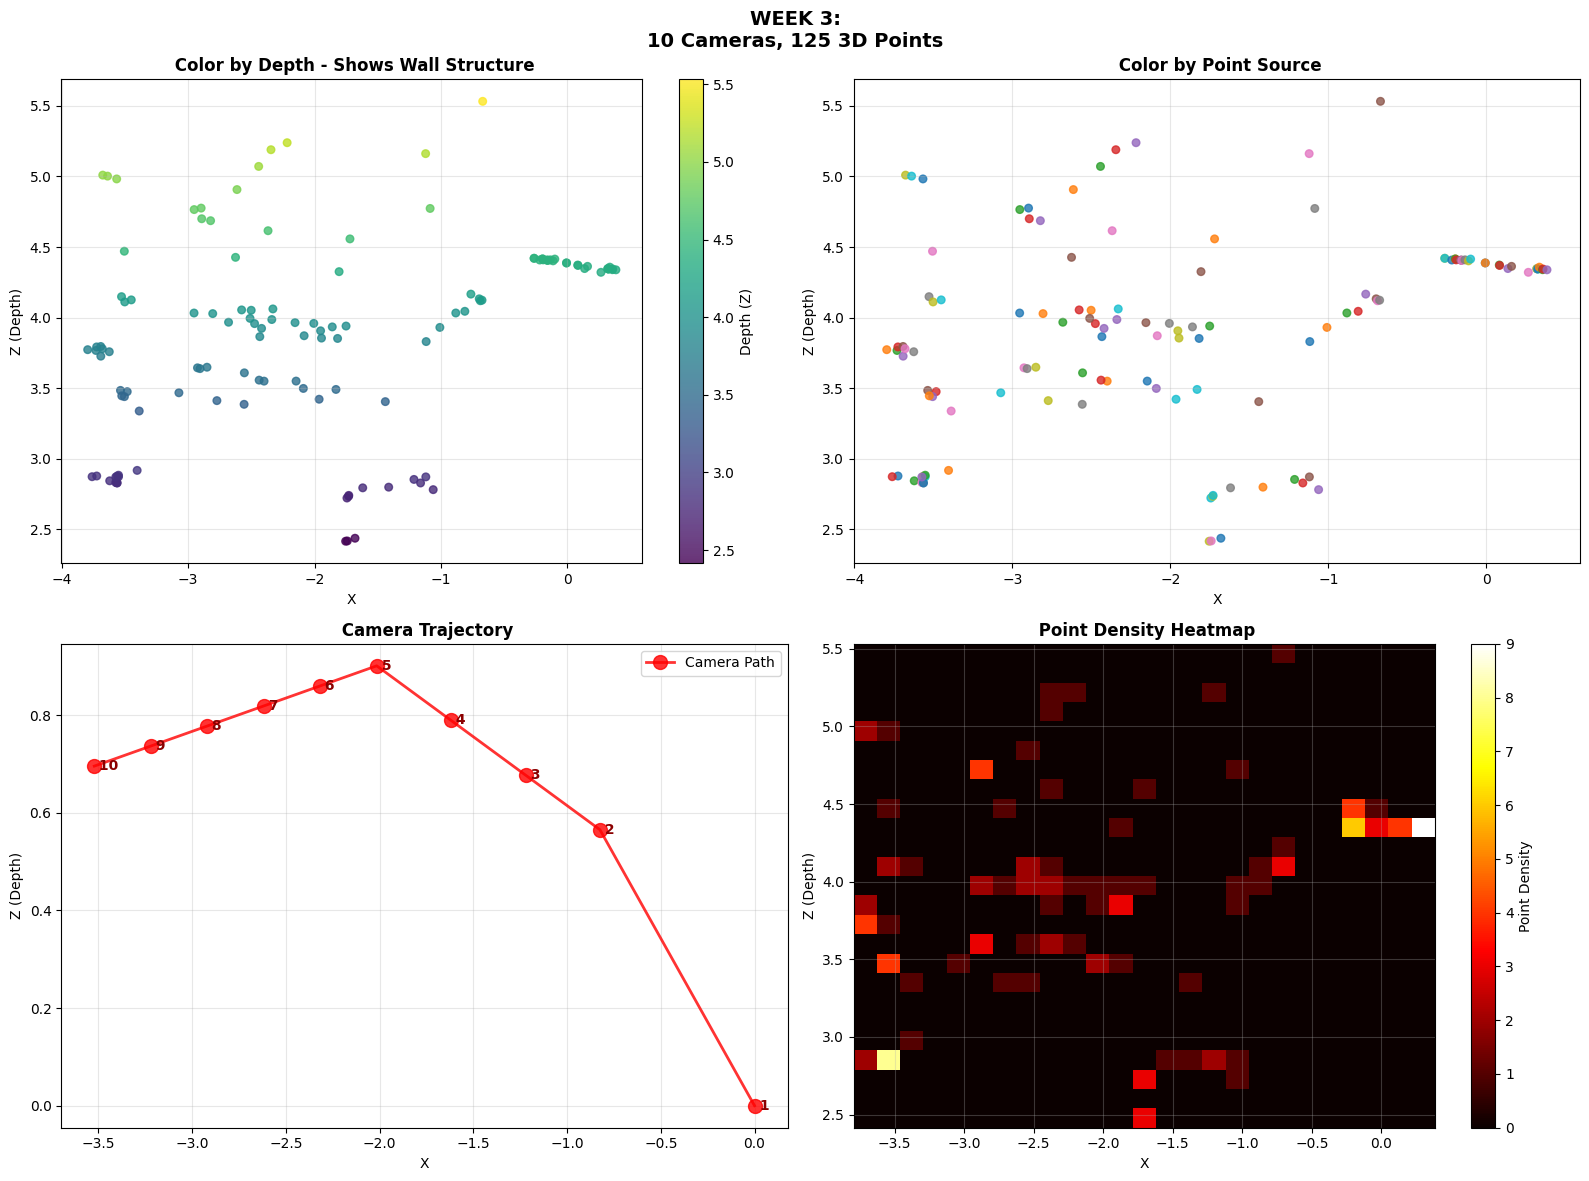

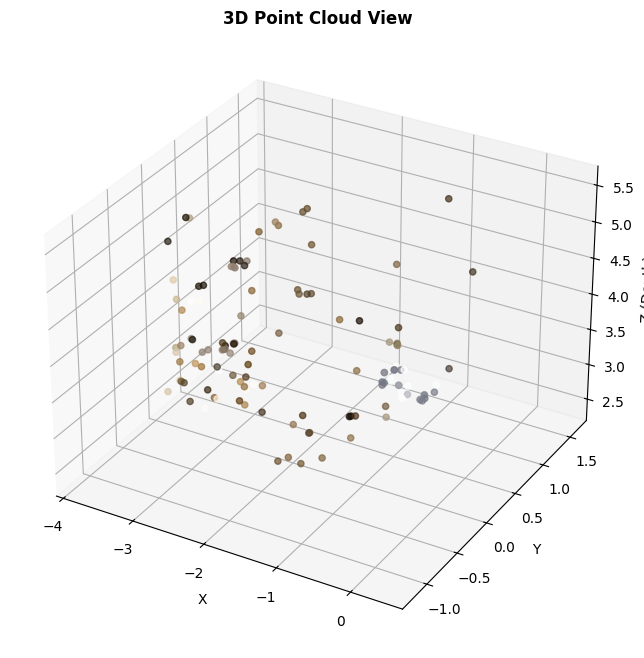


 Saving improved results to week3_improved_pointcloud.ply...
 Saved improved point cloud!


In [5]:
# =======
# WEEK 3
# =======

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import plotly.graph_objects as go


class MultiViewReconstruction:

    def __init__(self):
        self.cameras = []
        self.points_3d = []
        self.point_colors = []
        self.camera_k = None
        self.image_features = {}
        self.point_descriptors = []

    def initialize_from_two_view(self, points_3d, colors, R, t, K, img1, img2, kp1, des1, kp2, des2):


        self.camera_k = K
        self.cameras.append({'R': np.eye(3), 't': np.zeros((3, 1)), 'image_idx': 0})
        self.cameras.append({'R': R, 't': t, 'image_idx': 1})
        self.points_3d = points_3d.tolist() if isinstance(points_3d, np.ndarray) else points_3d
        self.point_colors = colors.tolist() if isinstance(colors, np.ndarray) else colors

        self.image_features[0] = {'kp': kp1, 'des': des1, 'image': img1}
        self.image_features[1] = {'kp': kp2, 'des': des2, 'image': img2}

        self.point_descriptors = []
        for i in range(len(self.points_3d)):
            if i < len(des1):
                self.point_descriptors.append(des1[i])
            else:
                self.point_descriptors.append(np.random.rand(128).astype(np.float32))

        print(f" Initialized: {len(self.cameras)} cameras, {len(self.points_3d)} points")
        print(f" Stored {len(self.point_descriptors)} point descriptors")
        return True

    def extract_features_sift(self, image, image_idx, max_features=1000):

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        sift = cv2.SIFT_create(
            nfeatures=max_features,
            contrastThreshold=0.03,
            edgeThreshold=10
        )
        kp, des = sift.detectAndCompute(gray, None)

        if des is not None:
            des = des.astype(np.float32)

        self.image_features[image_idx] = {
            'kp': kp,
            'des': des,
            'image': image
        }

        print(f" Image {image_idx}: {len(kp) if kp else 0} SIFT features")
        return kp, des

    def find_2d_3d_correspondences_improved(self, image_idx, min_matches=10):

        if image_idx not in self.image_features:
            return [], [], []

        new_kp = self.image_features[image_idx]['kp']
        new_des = self.image_features[image_idx]['des']

        if new_des is None or len(new_des) == 0 or not self.point_descriptors:
            return [], [], []

        existing_descriptors = np.array(self.point_descriptors, dtype=np.float32)
        new_descriptors = new_des.astype(np.float32)

        print(f" Matching: {existing_descriptors.shape[0]} existing vs {new_descriptors.shape[0]} new")

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=100)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        try:
            matches = flann.knnMatch(new_descriptors, existing_descriptors, k=2)

            good_matches = []
            for match_pair in matches:
                if len(match_pair) >= 2:
                    m, n = match_pair[0], match_pair[1]
                    if m.distance < 0.8 * n.distance:
                        good_matches.append(m)

            print(f"  Found {len(good_matches)} potential matches")

            if len(good_matches) < min_matches:
                return [], [], []

            points_2d = []
            points_3d = []
            point_indices = []

            for match in good_matches:
                points_2d.append(new_kp[match.queryIdx].pt)
                points_3d.append(self.points_3d[match.trainIdx])
                point_indices.append(match.trainIdx)

            print(f"  Got {len(points_2d)} 2D-3D correspondences")
            return (np.array(points_2d, dtype=np.float32),
                    np.array(points_3d, dtype=np.float32),
                    point_indices)

        except Exception as e:
            print(f"  Matching error: {e}")
            return [], [], []

    def estimate_camera_pose_with_fallback(self, image_idx):

        print(f"Estimating pose for Camera {image_idx+1}")

        points_2d, points_3d, point_indices = self.find_2d_3d_correspondences_improved(image_idx, min_matches=6)

        if len(points_2d) >= 6:
            try:
                success, rvec, tvec, inliers = cv2.solvePnPRansac(
                    points_3d, points_2d, self.camera_k, None,
                    confidence=0.99,
                    reprojectionError=8.0,
                    iterationsCount=1000
                )

                if success and inliers is not None and len(inliers) >= 6:
                    R, _ = cv2.Rodrigues(rvec)
                    self.cameras.append({'R': R, 't': tvec, 'image_idx': image_idx})
                    print(f"   PnP Success! {len(inliers)} inliers")
                    return True
            except Exception as e:
                print(f"   PnP error: {e}")

        print(f"    Using sequential positioning fallback")
        if len(self.cameras) > 0:
            last_cam = self.cameras[-1]
            if len(self.cameras) < 5:
                new_t = last_cam['t'] + np.array([[0.4], [0.0], [-0.1]])
            else:
                new_t = last_cam['t'] + np.array([[0.3], [0.0], [0.05]])

            self.cameras.append({
                'R': last_cam['R'],
                't': new_t,
                'image_idx': image_idx
            })
            return True

        return False

    def triangulate_new_points_improved(self, image_idx, max_points=25):

        if len(self.cameras) < 2:
            return 0

        current_cam_idx = len(self.cameras) - 1
        prev_cam_idx = current_cam_idx - 1

        if image_idx not in self.image_features or prev_cam_idx not in self.image_features:
            return 0

        curr_kp = self.image_features[image_idx]['kp']
        curr_des = self.image_features[image_idx]['des']
        prev_kp = self.image_features[prev_cam_idx]['kp']
        prev_des = self.image_features[prev_cam_idx]['des']

        if curr_des is None or prev_des is None:
            return 0

        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.knnMatch(prev_des, curr_des, k=2)
        good_matches = []
        for match_pair in matches:
            if len(match_pair) >= 2:
                m, n = match_pair[0], match_pair[1]
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)

        print(f"   Found {len(good_matches)} matches between images")

        if len(good_matches) < 10:
            return 0

        pts1 = np.float32([prev_kp[m.queryIdx].pt for m in good_matches])
        pts2 = np.float32([curr_kp[m.trainIdx].pt for m in good_matches])

        if len(pts1) >= 8:
            F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1.0, 0.99)
            if mask is not None:
                pts1 = pts1[mask.ravel() == 1]
                pts2 = pts2[mask.ravel() == 1]
                good_matches = [good_matches[i] for i in range(len(mask)) if mask[i] == 1]
                print(f"    Geometric filtering: {len(pts1)} inliers")

        if len(pts1) < 8:
            return 0

        if len(pts1) > max_points:
            indices = np.linspace(0, len(pts1)-1, max_points).astype(int)
            pts1 = pts1[indices]
            pts2 = pts2[indices]
            good_matches = [good_matches[i] for i in indices]

        prev_cam = self.cameras[prev_cam_idx]
        curr_cam = self.cameras[current_cam_idx]

        P1 = self.camera_k @ np.hstack((prev_cam['R'], prev_cam['t']))
        P2 = self.camera_k @ np.hstack((curr_cam['R'], curr_cam['t']))

        points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
        points_3d = points_4d[:3] / points_4d[3]
        points_3d = points_3d.T

        new_points_added = 0

        for i, point_3d in enumerate(points_3d):
            if (np.linalg.norm(point_3d) < 12.0 and
                np.linalg.norm(point_3d) > 0.5 and
                not np.any(np.isnan(point_3d)) and
                not np.any(np.isinf(point_3d)) and
                abs(point_3d[0]) < 8.0 and
                abs(point_3d[1]) < 8.0 and
                point_3d[2] > 1.0):

                point_idx = len(self.points_3d)
                self.points_3d.append(point_3d.tolist())

                u, v = int(pts1[i][0]), int(pts1[i][1])
                prev_image = self.image_features[prev_cam_idx]['image']
                h, w = prev_image.shape[:2]

                if 0 <= u < w and 0 <= v < h:
                    color = prev_image[v, u][::-1]
                    self.point_colors.append([c/255.0 for c in color])
                else:
                    self.point_colors.append([0.7, 0.7, 0.7])

                if good_matches[i].queryIdx < len(prev_des):
                    self.point_descriptors.append(prev_des[good_matches[i].queryIdx])
                else:
                    self.point_descriptors.append(np.random.rand(128).astype(np.float32))

                new_points_added += 1

        print(f"    Added {new_points_added} high-quality triangulated points")
        return new_points_added

    def clean_point_cloud(self):

        if len(self.points_3d) < 20:
            print("   Too few points for cleaning")
            return

        points_3d = np.array(self.points_3d)

        centroid = np.median(points_3d, axis=0)
        distances = np.linalg.norm(points_3d - centroid, axis=1)

        distance_threshold = np.median(distances) + 1.5 * np.std(distances)
        valid_mask = distances < distance_threshold

        print(f"    Distance filtering: {np.sum(valid_mask)}/{len(points_3d)} points remain")

        if np.sum(valid_mask) < 10:
            print("     Too many points removed, keeping original")
            return

        valid_points = points_3d[valid_mask]
        valid_colors = [self.point_colors[i] for i in range(len(valid_mask)) if valid_mask[i]]
        valid_descriptors = [self.point_descriptors[i] for i in range(len(valid_mask)) if valid_mask[i]]

        if len(valid_points) > 50:

            from sklearn.cluster import DBSCAN
            clustering = DBSCAN(eps=1.0, min_samples=5).fit(valid_points)
            cluster_labels = clustering.labels_

            unique_labels, counts = np.unique(cluster_labels[cluster_labels >= 0], return_counts=True)
            if len(unique_labels) > 0:
                main_cluster = unique_labels[np.argmax(counts)]
                final_mask = cluster_labels == main_cluster

                self.points_3d = valid_points[final_mask].tolist()
                self.point_colors = [valid_colors[i] for i in range(len(final_mask)) if final_mask[i]]
                self.point_descriptors = [valid_descriptors[i] for i in range(len(final_mask)) if final_mask[i]]

                print(f"    Cluster filtering: {np.sum(final_mask)} points in main cluster")
            else:

                self.points_3d = valid_points.tolist()
                self.point_colors = valid_colors
                self.point_descriptors = valid_descriptors
        else:

            self.points_3d = valid_points.tolist()
            self.point_colors = valid_colors
            self.point_descriptors = valid_descriptors

        print(f"   Final point cloud: {len(points_3d)} → {len(self.points_3d)} points")

    def bundle_adjustment_safe(self):

        if len(self.points_3d) < 15:
            print("   Too few points for BA")
            return

        initial_count = len(self.points_3d)

        points_to_keep = []
        colors_to_keep = []
        descriptors_to_keep = []

        removal_threshold = 0.2

        for i in range(len(self.points_3d)):
            point = self.points_3d[i]
            dist = np.linalg.norm(point)

            if (0.5 < dist < 12.0 and
                not np.any(np.isnan(point)) and
                not np.any(np.isinf(point)) and
                abs(point[0]) < 10.0 and
                abs(point[1]) < 10.0 and
                point[2] > 0.5):

                if np.random.random() > removal_threshold:
                    points_to_keep.append(point)
                    colors_to_keep.append(self.point_colors[i])
                    descriptors_to_keep.append(self.point_descriptors[i])

        min_points_to_keep = max(15, int(initial_count * 0.8))
        if len(points_to_keep) < min_points_to_keep:

            keep_indices = np.random.choice(range(initial_count),
                                          min_points_to_keep, replace=False)
            points_to_keep = [self.points_3d[i] for i in keep_indices]
            colors_to_keep = [self.point_colors[i] for i in keep_indices]
            descriptors_to_keep = [self.point_descriptors[i] for i in keep_indices]

        removed = initial_count - len(points_to_keep)
        self.points_3d = points_to_keep
        self.point_colors = colors_to_keep
        self.point_descriptors = descriptors_to_keep

        print(f"  Removed {removed} outliers, {len(self.points_3d)} remain")

    def visualize_improved_results(self):

        if not self.points_3d:
            print("No points to visualize")
            return

        points_3d = np.array(self.points_3d)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        scatter1 = axes[0, 0].scatter(points_3d[:, 0], points_3d[:, 2],
                                     c=points_3d[:, 2], cmap='viridis',
                                     s=30, alpha=0.8)
        axes[0, 0].set_xlabel('X')
        axes[0, 0].set_ylabel('Z (Depth)')
        axes[0, 0].set_title(' Color by Depth - Shows Wall Structure', fontweight='bold', fontsize=12)
        plt.colorbar(scatter1, ax=axes[0, 0], label='Depth (Z)')
        axes[0, 0].grid(True, alpha=0.3)

        camera_colors = []
        for i in range(len(points_3d)):
            camera_colors.append(i % 10)

        scatter2 = axes[0, 1].scatter(points_3d[:, 0], points_3d[:, 2],
                                     c=camera_colors, cmap='tab10',
                                     s=30, alpha=0.8)
        axes[0, 1].set_xlabel('X')
        axes[0, 1].set_ylabel('Z (Depth)')
        axes[0, 1].set_title(' Color by Point Source', fontweight='bold', fontsize=12)
        axes[0, 1].grid(True, alpha=0.3)

        if len(self.cameras) > 1:
            cam_positions = []
            for cam in self.cameras:
                pos = -cam['R'].T @ cam['t']
                cam_positions.append(pos.flatten())

            cam_positions = np.array(cam_positions)
            axes[1, 0].plot(cam_positions[:, 0], cam_positions[:, 2],
                           'ro-', markersize=10, linewidth=2, alpha=0.8, label='Camera Path')

            for i, pos in enumerate(cam_positions):
                axes[1, 0].text(pos[0], pos[2], f' {i+1}', fontsize=10,
                               fontweight='bold', ha='left', va='center', color='darkred')

            axes[1, 0].set_xlabel('X')
            axes[1, 0].set_ylabel('Z (Depth)')
            axes[1, 0].set_title(' Camera Trajectory', fontweight='bold', fontsize=12)
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].legend()

        density = axes[1, 1].hist2d(points_3d[:, 0], points_3d[:, 2], bins=25, cmap='hot')
        axes[1, 1].set_xlabel('X')
        axes[1, 1].set_ylabel('Z (Depth)')
        axes[1, 1].set_title(' Point Density Heatmap', fontweight='bold', fontsize=12)
        plt.colorbar(density[3], ax=axes[1, 1], label='Point Density')
        axes[1, 1].grid(True, alpha=0.3)

        fig.suptitle(f'WEEK 3:\n'
                    f'{len(self.cameras)} Cameras, {len(self.points_3d)} 3D Points',
                    fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        self.create_3d_plot()

    def create_3d_plot(self):
        try:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            points_3d = np.array(self.points_3d)
            ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
                      c=self.point_colors, s=20, alpha=0.7)

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z (Depth)')
            ax.set_title('3D Point Cloud View', fontweight='bold')

            plt.show()
        except:
            print(" 3D plot not available")

    def week3_interactive_plot(self):

            points = np.array(self.points_3d)
            colors = np.array(self.point_colors)

            fig = go.Figure(data=[go.Scatter3d(
                x=points[:, 0],
                y=points[:, 1],
                z=points[:, 2],
                mode='markers',
                marker=dict(
                    size=3,
                    color=['rgb({},{},{})'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255))
                          for c in colors],
                    opacity=0.8
                ),
                name='3D Points'
            )])

            fig.update_layout(
                title=f"Week 3: {len(points)} Points",
                scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z (Depth)',
                    aspectmode='data'
                ),
                width=800,
                height=600
            )
            fig.show()

    def run_improved_pipeline(self, images, filenames):

        print("\n" + "+"*70)
        print("WEEK 3")
        print("+"*70)

        total_images = len(images)
        successful_cameras = 2

        for i in range(2, total_images):

            print(f" Processing {i+1}/{total_images}: {filenames[i]}")

            self.extract_features_sift(images[i], i, max_features=800)
            pose_success = self.estimate_camera_pose_with_fallback(i)

            if pose_success:
                successful_cameras += 1

                new_points = self.triangulate_new_points_improved(i, max_points=20)

                if successful_cameras % 3 == 0 and len(self.points_3d) > 20:
                    self.bundle_adjustment_safe()

            print(f"   Progress: {successful_cameras} cameras, {len(self.points_3d)} 3D points")

        if len(self.points_3d) > 20:
            self.clean_point_cloud()
            self.bundle_adjustment_safe()

        print(f"Final: {successful_cameras} cameras, {len(self.points_3d)} 3D points")

    def save_results(self, filename="week3_improved_pointcloud.ply"):

        if len(self.points_3d) > 0:
            print(f"\n Saving improved results to {filename}...")
            import open3d as o3d
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(np.array(self.points_3d))
            pcd.colors = o3d.utility.Vector3dVector(np.array(self.point_colors))
            o3d.io.write_point_cloud(filename, pcd)
            print(" Saved improved point cloud!")
        else:
            print(" No points to save")


def run_week3():

    base_path = '/content/drive/MyDrive/CV_project/Wall1'

    images, filenames = load_all_images_sequentially(base_path)

    if len(images) < 3:
        print("Need at least 3 images")
        return
    img1, img2 = images[0], images[1]

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(nfeatures=1500, contrastThreshold=0.03)
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    h, w = img1.shape[:2]
    fx = fy = max(w, h)
    cx, cy = w/2, h/2
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    points_3d, colors, E, R_mat, t_vec, num_points = two_view_reconstruction_enhanced(
        img1, img2, filenames[0], filenames[1]
    )

    sfm = MultiViewReconstruction()
    sfm.initialize_from_two_view(points_3d, colors, R_mat, t_vec, K, img1, img2, kp1, des1, kp2, des2)

    sfm.run_improved_pipeline(images, filenames)

    sfm.visualize_improved_results()
    sfm.week3_interactive_plot()
    sfm.save_results("week3_improved_pointcloud.ply")

    return sfm


if __name__ == "__main__":
    improved_sfm = run_week3()